<a href="https://www.kaggle.com/code/atharvcode/chest-ct-scan-2?scriptVersionId=213790763" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import random
from PIL import Image

# -----------------------
# Device Configuration
# -----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# -----------------------
# Data Loading & Augmentation
# -----------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder("/kaggle/input/chest-ctscan-images/Data/train", transform=transform)
test_data = datasets.ImageFolder("/kaggle/input/chest-ctscan-images/Data/test", transform=transform)
valid_data = datasets.ImageFolder("/kaggle/input/chest-ctscan-images/Data/valid", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

num_classes = len(train_data.classes)

In [3]:
# -----------------------
# Function to Train Model
# -----------------------
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=10, model_name="model"):
    best_val_acc = 0.0
    early_stop_count = 0
    patience = 3  # Early stopping patience
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        train_acc = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        
        val_acc = evaluate_model(model, valid_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_count = 0
            torch.save(model.state_dict(), f"{model_name}_best_model.pth")
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print("Early stopping triggered.")
                break

In [4]:
# -----------------------
# Function to Evaluate Model
# -----------------------
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [5]:
# -----------------------
# Function to Display Classification Report & Confusion Matrix
# -----------------------
def generate_report(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [6]:
# -----------------------
# Function to Predict Image
# -----------------------
def predict_image(image_path, image_index=None, model=None):
    if model is None:
        raise ValueError("Model is not specified")
    
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_transform = transform(img).unsqueeze(0)

    img_transform = img_transform.to(device)

    with torch.no_grad():
        pred = model(img_transform)

    _, pred_class_indx = torch.max(pred, 1)
    class_labels = list(test_loader.dataset.class_to_idx.keys())
    pred_class_label = class_labels[pred_class_indx.item()]

    pred_score = torch.softmax(pred, dim=1)[0][pred_class_indx].item()

    if image_index is not None:
        return pred_class_label, pred_score, image_index, img
    else:
        return pred_class_label, pred_score, image_path, img

In [7]:
# -----------------------
# Model Setup and Execution
# -----------------------

# ResNet50
from torchvision.models import ResNet50_Weights
model_resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model_resnet50.fc = nn.Sequential(
    nn.Linear(model_resnet50.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
model_resnet50 = model_resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_resnet50.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_model(model_resnet50, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=10, model_name="resnet50")

test_acc = evaluate_model(model_resnet50, test_loader)
print(f"ResNet50 Test Accuracy: {test_acc:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 26.0MB/s]


Epoch [1/10], Loss: 1.2030, Train Acc: 45.35%, Val Acc: 30.56%
Epoch [2/10], Loss: 1.0519, Train Acc: 52.37%, Val Acc: 40.28%
Epoch [3/10], Loss: 1.0054, Train Acc: 55.14%, Val Acc: 50.00%
Epoch [4/10], Loss: 0.9428, Train Acc: 55.95%, Val Acc: 44.44%
Epoch [5/10], Loss: 0.8865, Train Acc: 56.61%, Val Acc: 43.06%
Epoch [6/10], Loss: 0.8341, Train Acc: 62.32%, Val Acc: 50.00%
Early stopping triggered.
ResNet50 Test Accuracy: 56.83%


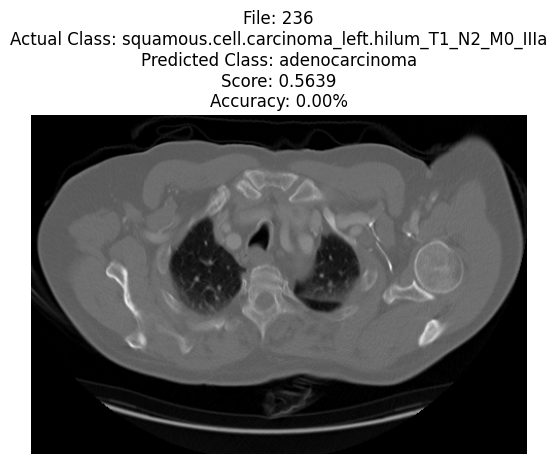

In [8]:
# -----------------------
# Random Image Prediction
# -----------------------
random_index = random.randint(0, len(test_data) - 1)
image_file, actual_label = test_data.imgs[random_index]
predicted_label, predicted_score, file_info, img = predict_image(image_file, random_index, model=model_resnet50)
accuracy = (predicted_label == train_data.classes[actual_label]) * 100

plt.imshow(img)
plt.title(f"File: {file_info}\nActual Class: {train_data.classes[actual_label]}\nPredicted Class: {predicted_label}\nScore: {predicted_score:.4f}\nAccuracy: {accuracy:.2f}%")
plt.axis('off')
plt.show()

In [9]:

# MobileNetV2
from torchvision.models import MobileNet_V2_Weights
model_mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model_mobilenet.classifier[-1] = nn.Linear(model_mobilenet.classifier[-1].in_features, num_classes)
model_mobilenet = model_mobilenet.to(device)

optimizer = Adam(model_mobilenet.parameters(), lr=0.001)

train_model(model_mobilenet, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=10, model_name="mobilenetv2")

test_acc = evaluate_model(model_mobilenet, test_loader)
print(f"MobileNetV2 Test Accuracy: {test_acc:.2f}%")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 12.2MB/s]


Epoch [1/10], Loss: 1.0279, Train Acc: 59.22%, Val Acc: 48.61%
Epoch [2/10], Loss: 0.6157, Train Acc: 75.20%, Val Acc: 66.67%
Epoch [3/10], Loss: 0.4619, Train Acc: 83.36%, Val Acc: 72.22%
Epoch [4/10], Loss: 0.4058, Train Acc: 83.03%, Val Acc: 83.33%
Epoch [5/10], Loss: 0.3813, Train Acc: 88.91%, Val Acc: 69.44%
Epoch [6/10], Loss: 0.4128, Train Acc: 88.09%, Val Acc: 81.94%
Epoch [7/10], Loss: 0.3472, Train Acc: 88.25%, Val Acc: 81.94%
Early stopping triggered.
MobileNetV2 Test Accuracy: 79.37%


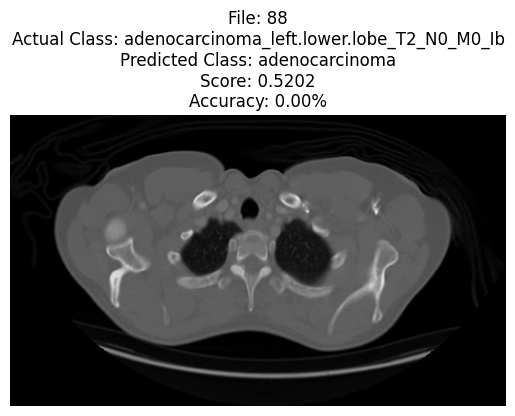

In [10]:
# -----------------------
# Random Image Prediction
# -----------------------
random_index = random.randint(0, len(test_data) - 1)
image_file, actual_label = test_data.imgs[random_index]
predicted_label, predicted_score, file_info, img = predict_image(image_file, random_index, model=model_mobilenet)
accuracy = (predicted_label == train_data.classes[actual_label]) * 100

plt.imshow(img)
plt.title(f"File: {file_info}\nActual Class: {train_data.classes[actual_label]}\nPredicted Class: {predicted_label}\nScore: {predicted_score:.4f}\nAccuracy: {accuracy:.2f}%")
plt.axis('off')
plt.show()